In [1]:
import numpy as np
from numpy.random import default_rng

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    Matern,
    ConstantKernel as C,
    WhiteKernel,
)

# ============================================================
# Global model settings
# ============================================================

GRID_SIZE = 100            # 200x200 grid over 10km x 10km
DOMAIN_KM = 5.0
CELL_SIZE_KM = DOMAIN_KM / GRID_SIZE

NUM_DRONES = 3             # number of retardant lines (drones)
LINE_LENGTH_CELLS = 40     # ~2km
LINE_WIDTH_CELLS = 3       # ~150m

T_HORIZON_MIN = 30.0
DT_MIN = 0.5
N_STEPS = int(T_HORIZON_MIN / DT_MIN)

BASE_SPREAD_PROB = 0.25    # base ignition probability per step
WIND_DIR = np.array([-1.0, 0.0])  # wind blowing to the East
WIND_STRENGTH = 2        # controls anisotropy
RETARDANT_SPREAD_FACTOR = 0.02  # multiplier for spread prob in treated cells

# For stochasticity in the simulator
GLOBAL_RNG = default_rng(123)


# ============================================================
# Utility: value map (higher value near "town" on the right)
# ============================================================

def build_value_map():
    """
    Creates a value map over the grid. For simplicity:
    - Baseline value = 1 everywhere.
    - Extra high value near the right side (a 'town' region).
    """
    x = np.linspace(0, DOMAIN_KM, GRID_SIZE)
    y = np.linspace(0, DOMAIN_KM, GRID_SIZE)
    X, Y = np.meshgrid(x, y, indexing="ij")

    # Place a "town" as a 2D Gaussian near the east side
    town_center_x = 3.5  # km
    town_center_y = 2.5  # km
    sigma = 0.75          # km

    gauss = np.exp(-((X - town_center_x) ** 2 + (Y - town_center_y) ** 2) / (2 * sigma ** 2))
    value_map = 1.0 + 10.0 * gauss

    return value_map


VALUE_MAP = build_value_map()


# ============================================================
# Fire model: initial condition & anisotropic CA update
# ============================================================

def initial_fire_front():
    """
    Create a partially developed fire front on the left side.
    We use state:
        0 = unburned
        1 = burning
        2 = burned
    """
    state = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.int8)

    # Example: a vertical band of burning cells near the left edge
    start_x = 20  # ~1km in
    state[start_x:start_x + 2, GRID_SIZE // 4 : 3 * GRID_SIZE // 4] = 1

    return state


# Precompute neighbor offsets and wind-driven directional weights
NEIGHBOR_OFFSETS = []
NEIGHBOR_WEIGHTS = []
_wind_unit = WIND_DIR / (np.linalg.norm(WIND_DIR) + 1e-12)

for dx in [-1, 0, 1]:
    for dy in [-1, 0, 1]:
        if dx == 0 and dy == 0:
            continue
        NEIGHBOR_OFFSETS.append((dx, dy))
        direction = np.array([dx, dy], dtype=float)
        norm = np.linalg.norm(direction)
        if norm == 0:
            cos_theta = 0.0
        else:
            cos_theta = np.dot(direction / norm, _wind_unit)
        # More weight if direction aligns with wind
        weight = np.exp(WIND_STRENGTH * cos_theta)
        NEIGHBOR_WEIGHTS.append(weight)

NEIGHBOR_OFFSETS = np.array(NEIGHBOR_OFFSETS)
NEIGHBOR_WEIGHTS = np.array(NEIGHBOR_WEIGHTS)


def simulate_fire(retardant_mask, rng, n_steps=N_STEPS):
    """
    Run the anisotropic CA fire simulation for n_steps.
    Arguments:
        retardant_mask: boolean array [G, G], True where retardant is present.
        rng: numpy Generator for randomness.
        n_steps: number of time steps to simulate (each ~1 minute).
    Returns:
        burned_mask: boolean [G, G], True if cell burned by time T.
    """
    state = initial_fire_front()  # 0=unburned, 1=burning, 2=burned
    burning = (state == 1)
    burned = (state == 2)

    for _ in range(n_steps):
        new_burning = np.zeros_like(burning, dtype=bool)

        # Cells currently burning become burned
        burned = burned | burning

        # Candidates for ignition: currently unburned & not already burning
        unburned = ~(burned | burning)

        # For each neighbor direction, compute ignitions
        for (dx, dy), weight in zip(NEIGHBOR_OFFSETS, NEIGHBOR_WEIGHTS):
            src_x = np.clip(np.arange(GRID_SIZE)[:, None] + dx, 0, GRID_SIZE - 1)
            src_y = np.clip(np.arange(GRID_SIZE)[None, :] + dy, 0, GRID_SIZE - 1)

            # burning neighbors
            neighbor_burning = burning[src_x, src_y]

            # base anisotropic spread probability from that neighbor
            p_spread = BASE_SPREAD_PROB * weight

            # retardant effect
            p_spread = np.where(retardant_mask & unburned, p_spread * RETARDANT_SPREAD_FACTOR, p_spread)

            # sample ignition
            rand = rng.random((GRID_SIZE, GRID_SIZE))
            ignited = (rand < p_spread) & neighbor_burning & unburned

            new_burning |= ignited

        burning = new_burning

        # Stop early if no active fire
        if not burning.any():
            break

    burned |= burning
    return burned


# ============================================================
# Retardant geometry: lines from drone params
# ============================================================

def lines_from_theta(theta):
    """
    Decode theta into drone line parameters.

    theta is a 1D array of length 3 * NUM_DRONES, with elements in [0, 1]:
        for each drone d:
            theta[3d]   = x_norm  in [0, 1]
            theta[3d+1] = y_norm  in [0, 1]
            theta[3d+2] = phi_norm in [0, 1], mapped to [0, pi)
    Returns:
        list of (cx, cy, phi) in grid coordinates (cells, radians).
    """
    params = []
    for d in range(NUM_DRONES):
        x_norm = theta[3 * d]
        y_norm = theta[3 * d + 1]
        phi_norm = theta[3 * d + 2]

        cx = int(x_norm * (GRID_SIZE - 1))
        cy = int(y_norm * (GRID_SIZE - 1))
        phi = phi_norm * np.pi  # [0, pi)

        params.append((cx, cy, phi))

    return params


def build_retardant_mask(theta):
    """
    Given theta, build a boolean mask [G, G] where True indicates
    cells covered by retardant lines.
    """
    mask = np.zeros((GRID_SIZE, GRID_SIZE), dtype=bool)
    lines = lines_from_theta(theta)

    half_len = LINE_LENGTH_CELLS // 2
    half_width = LINE_WIDTH_CELLS // 2

    for (cx, cy, phi) in lines:
        # direction vector along the line
        dx = np.cos(phi)
        dy = np.sin(phi)
        # perpendicular direction
        px = -dy
        py = dx

        for s in range(-half_len, half_len + 1):
            for w in range(-half_width, half_width + 1):
                x = int(round(cx + s * dx + w * px))
                y = int(round(cy + s * dy + w * py))
                if 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE:
                    mask[x, y] = True

    return mask


# ============================================================
# Objective: value-weighted burned area
# ============================================================

def compute_value_weighted_loss(burned_mask):
    """
    Compute the loss as value-weighted burned area.
    """
    # burn indicator is 1 where burned
    burned = burned_mask.astype(float)

    cell_area = CELL_SIZE_KM ** 2
    loss = np.sum(VALUE_MAP * burned) * cell_area
    return loss


def objective(theta, n_mc=3, rng=None):
    """
    Stochastic objective: average value-weighted burned area
    over n_mc Monte Carlo replicates of the fire simulation.
    """
    if rng is None:
        rng = GLOBAL_RNG

    theta = np.asarray(theta)
    retardant_mask = build_retardant_mask(theta)  # deterministic given theta

    losses = []
    for _ in range(n_mc):
        # Use a fresh RNG for each replicate
        local_rng = default_rng(rng.integers(1, 1_000_000))
        burned = simulate_fire(retardant_mask, local_rng, n_steps=N_STEPS)
        loss = compute_value_weighted_loss(burned)
        losses.append(loss)

    return float(np.mean(losses))


# ============================================================
# Bayesian optimisation setup (Matérn 5/2 with ARD)
# ============================================================

def propose_random_thetas(n_samples, rng=None):
    """
    Sample n_samples random theta in [0,1]^{3*NUM_DRONES}.
    """
    if rng is None:
        rng = GLOBAL_RNG
    return rng.random((n_samples, 3 * NUM_DRONES))


def expected_improvement(X_candidates, gp, y_best, xi=0.01):
    """
    Compute Expected Improvement for a batch of candidate points.
    """
    from scipy.stats import norm

    mu, sigma = gp.predict(X_candidates, return_std=True)
    sigma = sigma.reshape(-1, 1)
    sigma = np.clip(sigma, 1e-8, None)   # avoid zero / negative
    mu = mu.reshape(-1, 1)

    # We are minimizing: improvement = y_best - f(x)
    with np.errstate(divide="warn"):
        Z = (y_best - mu - xi) / sigma
        ei = (y_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.ravel()


def bayesian_optimisation( #current isotropic kernel
    n_init=10,
    n_iter=40,
    n_candidates=1000,
    n_mc_obj=3,
    rng=None,
):
    """
    Run BO with a GP + Matérn 5/2 (isotropic) on the drone-placement problem.
    We use ONE shared length-scale for all dimensions (no ARD), so
    all drone x/y/phi are treated with the same smoothness scale.
    """
    if rng is None:
        rng = GLOBAL_RNG

    dim = 3 * NUM_DRONES
    X = []
    y = []

    # --- Initial design
    X_init = propose_random_thetas(n_init, rng)
    for x in X_init:
        y_val = objective(x, n_mc=n_mc_obj, rng=rng)
        X.append(x)
        y.append(y_val)

    X = np.array(X)
    y = np.array(y)

    # --- Set up GP with Matérn 5/2, *isotropic* (single length_scale)
    # No ARD here: one ℓ shared across all input dims.
    kernel = (
        C(1.0, (0.1, 10.0))
        * Matern(
            length_scale=0.5,                # initial guess
            length_scale_bounds=(0.1, 2.0),  # reasonable global scale
            nu=2.5,
        )
        + WhiteKernel(
            noise_level=1e-2,
            noise_level_bounds=(1e-4, 1e0),
        )
    )

    gp = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=5,
        alpha=1e-6,  # noise is in WhiteKernel
        random_state=rng.integers(1_000_000),
    )

    history = {"X": [], "y": [], "y_best": []}
    history["X"].extend(X.tolist())
    history["y"].extend(y.tolist())
    history["y_best"].append(float(np.min(y)))

    for it in range(n_iter):
        # Fit GP hyperparameters (single length-scale + noise) via ML
        gp.fit(X, y)

        # Candidate pool for acquisition maximisation
        X_cand = propose_random_thetas(n_candidates, rng)
        ei = expected_improvement(X_cand, gp, y_best=np.min(y))
        best_idx = np.argmax(ei)
        x_next = X_cand[best_idx]

        # Evaluate true objective
        y_next = objective(x_next, n_mc=n_mc_obj, rng=rng)

        # Augment dataset
        X = np.vstack([X, x_next])
        y = np.concatenate([y, [y_next]])

        history["X"].append(x_next.tolist())
        history["y"].append(float(y_next))
        history["y_best"].append(float(np.min(y)))

        print(f"[BO] Iter {it+1}/{n_iter}, f(x_next) = {y_next:.3f}, best = {np.min(y):.3f}")

    print("\nFinal GP kernel:", gp.kernel_)
    return X, y, history

# ============================================================
# Random search baseline
# ============================================================

def random_search(n_evals=50, n_mc_obj=3, rng=None):
    """
    Simple random search baseline in [0,1]^{3*NUM_DRONES}.
    """
    if rng is None:
        rng = GLOBAL_RNG

    X = propose_random_thetas(n_evals, rng)
    y = []
    y_best = []

    best_so_far = np.inf
    for i, x in enumerate(X):
        y_val = objective(x, n_mc=n_mc_obj, rng=rng)
        y.append(y_val)
        best_so_far = min(best_so_far, y_val)
        y_best.append(best_so_far)
        print(f"[Random] Eval {i+1}/{n_evals}, f(x) = {y_val:.3f}, best = {best_so_far:.3f}")

    return X, np.array(y), np.array(y_best)

# ============================================================
# Visualising the solution
# ============================================================

import matplotlib.pyplot as plt


def get_best_theta(X, y):
    """Return theta corresponding to the minimum loss."""
    idx_best = np.argmin(y)
    return X[idx_best]

def plot_solution(theta, seed=123):
    """
    Visualise:
      - value map
      - burned area after T
      - retardant lines
      - initial front (optional)
    """
    # Build retardant mask
    retardant_mask = build_retardant_mask(theta)

    # One simulation for visualisation
    rng_vis = default_rng(seed)
    burned = simulate_fire(retardant_mask, rng_vis, n_steps=N_STEPS)

    # Also get initial front for plotting
    init_state = initial_fire_front()
    init_burning = (init_state == 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ------------------------------------------------
    # Left: value map + town + retardant lines
    # ------------------------------------------------
    ax = axes[0]
    im0 = ax.imshow(
        VALUE_MAP.T,
        origin="lower",
        cmap="viridis",
        extent=[0, DOMAIN_KM, 0, DOMAIN_KM],
        aspect="equal",
    )
    plt.colorbar(im0, ax=ax, label="Value weight")

    # Overlay retardant mask (semi-transparent)
    ax.imshow(
        np.where(retardant_mask, 1.0, np.nan).T,
        origin="lower",
        cmap="Reds",
        alpha=0.4,
        extent=[0, DOMAIN_KM, 0, DOMAIN_KM],
        aspect="equal",
    )

    ax.set_title("Value map + retardant lines")
    ax.set_xlabel("x (km)")
    ax.set_ylabel("y (km)")

    # ------------------------------------------------
    # Right: burned area + initial front + retardant
    # ------------------------------------------------
    ax = axes[1]

    # Burned area
    im1 = ax.imshow(
        burned.T,
        origin="lower",
        cmap="Oranges",
        extent=[0, DOMAIN_KM, 0, DOMAIN_KM],
        aspect="equal",
    )
    plt.colorbar(im1, ax=ax, label="Burned indicator")

    # Initial burning front outline
    ax.contour(
        init_burning.T,
        levels=[0.5],
        colors="blue",
        linewidths=1.0,
        origin="lower",
        extent=[0, DOMAIN_KM, 0, DOMAIN_KM],
    )

    # Retardant lines again
    ax.imshow(
        np.where(retardant_mask, 1.0, np.nan).T,
        origin="lower",
        cmap="Reds",
        alpha=0.4,
        extent=[0, DOMAIN_KM, 0, DOMAIN_KM],
        aspect="equal",
    )

    ax.set_title("Burned area at T={} min".format(T_HORIZON_MIN))
    ax.set_xlabel("x (km)")
    ax.set_ylabel("y (km)")

    plt.tight_layout()
    plt.show()

def plot_initial_state():
    # Initial state and burning mask
    state0 = initial_fire_front()       # 0 = unburned, 1 = burning, 2 = burned
    burning0 = (state0 == 1)

    plt.figure(figsize=(6, 5))

    # Background: value map
    im = plt.imshow(
        VALUE_MAP.T,
        origin="lower",
        cmap="viridis",
        extent=[0, DOMAIN_KM, 0, DOMAIN_KM],
        aspect="equal",
    )
    plt.colorbar(im, label="Value weight")

    # Overlay: initial fire front as contour
    plt.contour(
        burning0.T,
        levels=[0.5],
        colors="red",
        linewidths=2.0,
        origin="lower",
        extent=[0, DOMAIN_KM, 0, DOMAIN_KM],
    )

    plt.title("Initial fire front over value map")
    plt.xlabel("x (km)")
    plt.ylabel("y (km)")
    plt.tight_layout()
    plt.show()


Loss (no lines): 42.1491008324888
Loss (protect town line): 38.1269642833328


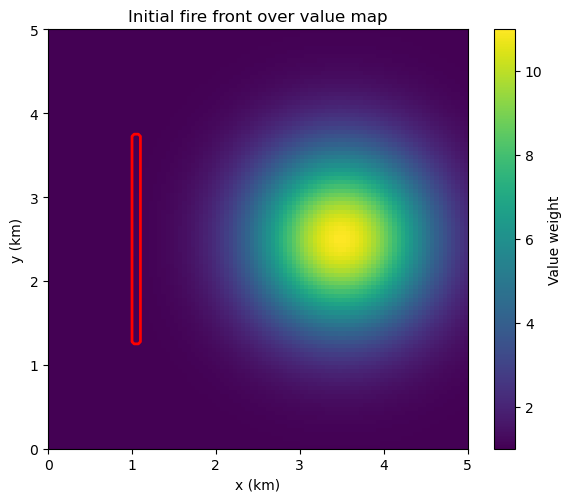

In [2]:
""" No retardant """

theta_none = np.zeros(3 * NUM_DRONES)  # lines all clumped in one place
loss_none = objective(theta_none, n_mc=20)
print("Loss (no lines):", loss_none)

""" Human designed line """

# x near 7–8 km; y near town y; phi ~0 (horizontal)
theta_protect = np.zeros(3 * NUM_DRONES)
theta_protect[0] = 0.5    # x_norm
theta_protect[1] = 0.5     # y_norm
theta_protect[2] = np.pi/2     # phi_norm -> 0 rad

loss_protect = objective(theta_protect, n_mc=20)
print("Loss (protect town line):", loss_protect)

plot_initial_state()

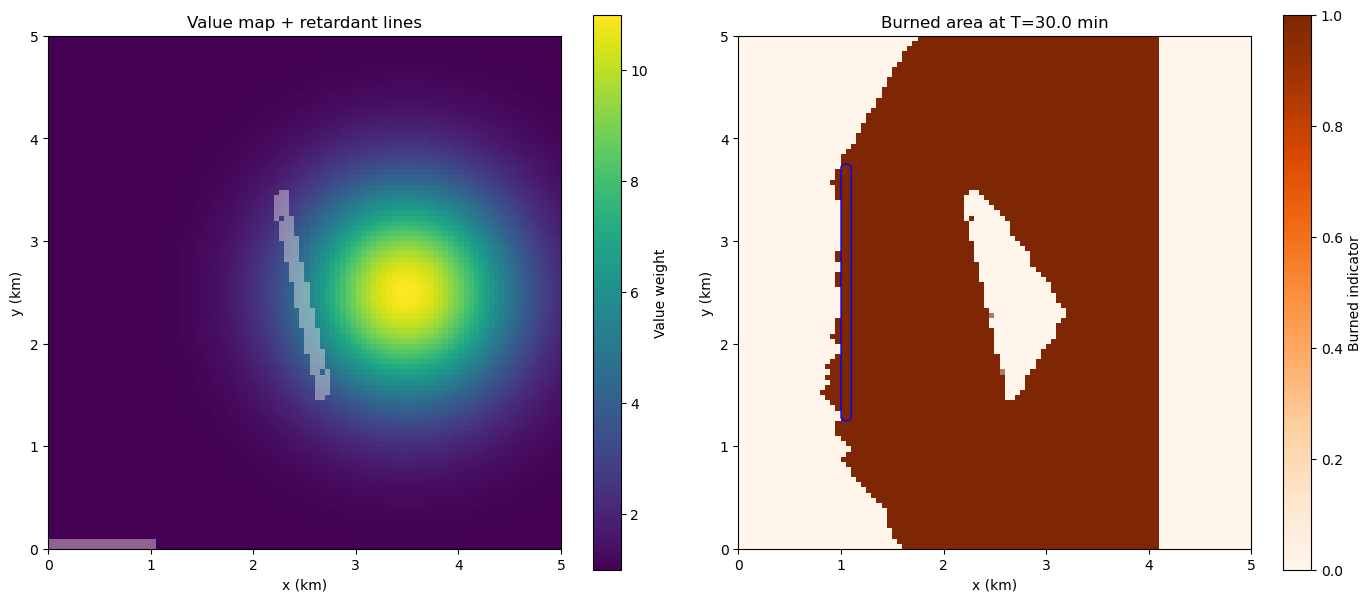

In [3]:
theta_protect = np.zeros(3 * NUM_DRONES)
theta_protect[0] = 0.5    # x_norm
theta_protect[1] = 0.5     # y_norm
theta_protect[2] = np.pi/2     # phi_norm -> 0 rad

plot_solution(theta_protect,seed=np.random.randint(0,1000))

=== Random Search Baseline ===
[Random] Eval 1/100, f(x) = 38.947, best = 38.947
[Random] Eval 2/100, f(x) = 39.099, best = 38.947
[Random] Eval 3/100, f(x) = 40.980, best = 38.947
[Random] Eval 4/100, f(x) = 39.522, best = 38.947
[Random] Eval 5/100, f(x) = 35.827, best = 35.827
[Random] Eval 6/100, f(x) = 38.198, best = 35.827
[Random] Eval 7/100, f(x) = 39.727, best = 35.827
[Random] Eval 8/100, f(x) = 38.921, best = 35.827
[Random] Eval 9/100, f(x) = 40.445, best = 35.827
[Random] Eval 10/100, f(x) = 40.471, best = 35.827
[Random] Eval 11/100, f(x) = 38.926, best = 35.827
[Random] Eval 12/100, f(x) = 40.495, best = 35.827
[Random] Eval 13/100, f(x) = 39.457, best = 35.827
[Random] Eval 14/100, f(x) = 41.981, best = 35.827
[Random] Eval 15/100, f(x) = 39.046, best = 35.827
[Random] Eval 16/100, f(x) = 41.404, best = 35.827
[Random] Eval 17/100, f(x) = 39.773, best = 35.827
[Random] Eval 18/100, f(x) = 37.732, best = 35.827
[Random] Eval 19/100, f(x) = 40.433, best = 35.827
[Random] 

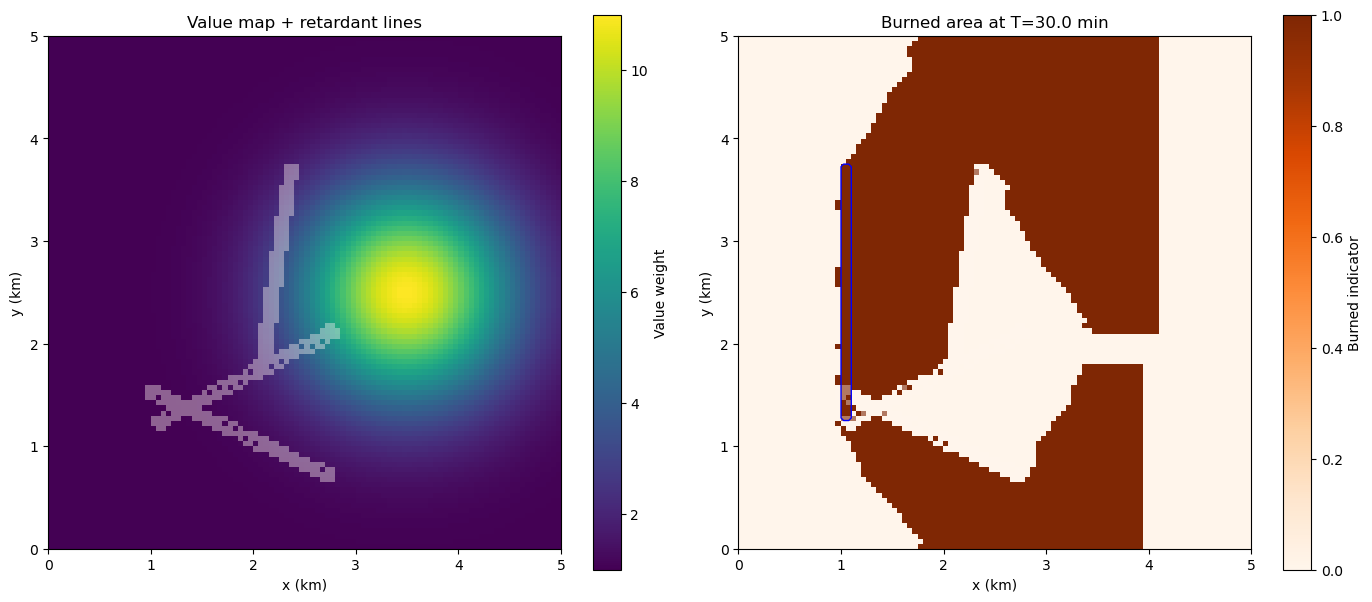

In [4]:
# ============================================================
# Main: run BO vs random
# ============================================================

n_budget = 100
n_init_bo = 10

print("=== Random Search Baseline ===")
X_rand, y_rand, y_best_rand = random_search(
    n_evals=n_budget,
    n_mc_obj=10,
)

print("\nRandom search best loss:", float(np.min(y_rand)))

# For comparison, best random solution
theta_best_rand = get_best_theta(X_rand, y_rand)
plot_solution(theta_best_rand)



In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [6]:
print("\n=== Bayesian Optimisation ===")
X_bo, y_bo, history_bo = bayesian_optimisation(
    n_init=50,
    n_iter=n_budget-n_init_bo,
    n_candidates=1000,
    n_mc_obj=20,
)


=== Bayesian Optimisation ===
[BO] Iter 1/90, f(x_next) = 29.688, best = 26.875
[BO] Iter 2/90, f(x_next) = 39.970, best = 26.875
[BO] Iter 3/90, f(x_next) = 33.851, best = 26.875
[BO] Iter 4/90, f(x_next) = 33.452, best = 26.875
[BO] Iter 5/90, f(x_next) = 39.229, best = 26.875
[BO] Iter 6/90, f(x_next) = 39.088, best = 26.875
[BO] Iter 7/90, f(x_next) = 36.236, best = 26.875
[BO] Iter 8/90, f(x_next) = 36.311, best = 26.875
[BO] Iter 9/90, f(x_next) = 35.361, best = 26.875
[BO] Iter 10/90, f(x_next) = 32.531, best = 26.875
[BO] Iter 11/90, f(x_next) = 39.109, best = 26.875
[BO] Iter 12/90, f(x_next) = 35.194, best = 26.875
[BO] Iter 13/90, f(x_next) = 35.760, best = 26.875
[BO] Iter 14/90, f(x_next) = 35.927, best = 26.875
[BO] Iter 15/90, f(x_next) = 38.927, best = 26.875
[BO] Iter 16/90, f(x_next) = 32.945, best = 26.875
[BO] Iter 17/90, f(x_next) = 38.635, best = 26.875
[BO] Iter 18/90, f(x_next) = 39.607, best = 26.875
[BO] Iter 19/90, f(x_next) = 38.270, best = 26.875
[BO] Iter

BO best loss:            24.265406004916066


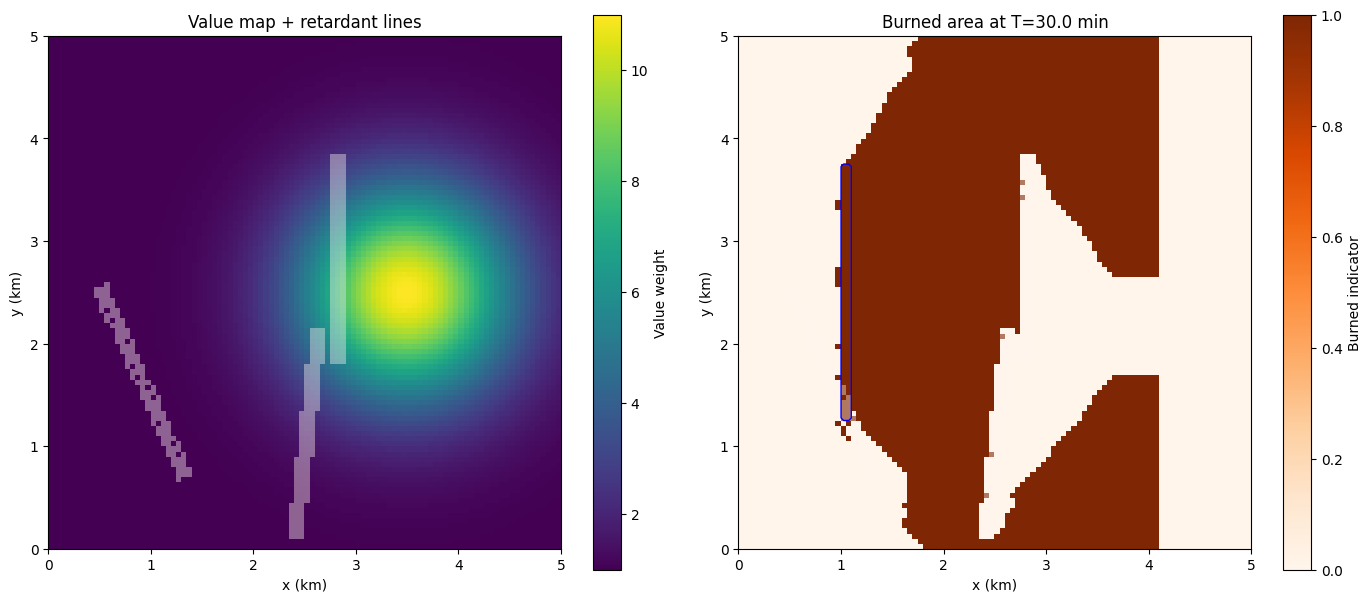

In [180]:
print("BO best loss:           ", float(np.min(y_bo)))

# After BO run
theta_best_bo = get_best_theta(X_bo, y_bo)
plot_solution(theta_best_bo)